In [144]:
import numpy as np
import sys

sys.path.insert(1, 'linear-regressions-mixture')
from src import LinearRegressionsMixture
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.linear_model import LinearRegression
from edward.models import Categorical, Mixture, Normal
import edward as ed
import tensorflow as tf
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor

[[1.]]
[[1.         0.99833541 0.99335826 ... 0.02521961 0.021528   0.01831564]
 [0.99833541 1.         0.99833541 ... 0.02944598 0.02521961 0.021528  ]
 [0.99335826 0.99833541 1.         ... 0.03426625 0.02944598 0.02521961]
 ...
 [0.02521961 0.02944598 0.03426625 ... 1.         0.99833541 0.99335826]
 [0.021528   0.02521961 0.02944598 ... 0.99833541 1.         0.99833541]
 [0.01831564 0.021528   0.02521961 ... 0.99335826 0.99833541 1.        ]]
(50, 50)
0.1534770877416155


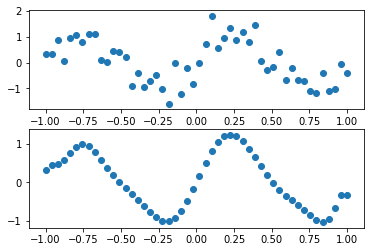

In [231]:
size=50
x = np.linspace(-1, 1, size)
f = 1
y = np.sin(f*2*np.pi*x) + np.random.normal(0, 0.4, size=size)

size=100
x_test = np.linspace(-1, 1, size)
f = 1
y_test = np.sin(f*2*np.pi*x_test) + np.random.normal(0, 0.4, size=size)

x_test = np.reshape(x_test, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
x_test_rbf = rbf_kernel(np.reshape(x_test[0], (-1,1)), gamma=1) 
#x_test_rbf = np.reshape(x_test_rbf, (-1, 1))
print(x_test_rbf)
#kernel = rb(gamma=1)
x = np.reshape(x, (-1, 1))
#y = np.reshape(y, (-1, 1))
x_rbf = rbf_kernel(x)
print(x_rbf)
print(x_rbf.shape)
#x_rbf = np.reshape(x_rbf, (-1, 1))

plt.subplot(211)
plt.scatter(x,y)

plt.subplot(212)
#plt.scatter(x_rbf[4],y)

lg = LinearRegression()#GaussianProcessRegressor(alpha=0.65, kernel=kernel)#
lg.fit(x_rbf, y)
pred = lg.predict(x_rbf)
plt.scatter(x, pred)
print( ( (y - pred)**2 ).mean() )

In [226]:
K = 5
epsilon = 0.01
lam = 0.0000002
iterations = 1000
random_restarts = 20

#x = np.reshape(x, (-1, 1))
y = np.reshape(y, (-1, 1))

model = LinearRegressionsMixture(x_rbf, y, K=K)
model.train(epsilon=epsilon, lam=lam, iterations=iterations, random_restarts=random_restarts, verbose=False)

Random restarts (20/20): [####################] 100% Elapsed time: 0:00:01


0.955130625878138


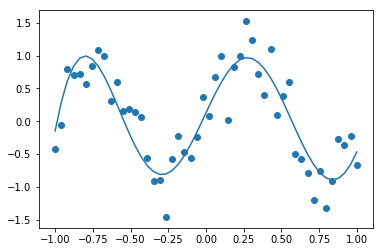

In [227]:
#x_new = np.linspace(-1, 1, size*3)
y_new = np.array([])

for xx in x_rbf:
    y_new = np.append(y_new, model.predict(xx))
plt.scatter(x, y)
plt.plot(x, y_new)
print( ( (y - y_new)**2 ).mean() )

In [228]:
pred_test = np.array([])

for xx in x_test_rbf:
    pred_test = np.append(pred_test, model.predict(xx))
    
print(((y_test-pred_test)**2).mean())

ModelError: Invalid size for new data point (100 instead of 50)

In [180]:
rx = np.ones((size, 2))
rx[:, 1] = np.reshape(x, -1)

for k in range(K):
    
    pred = np.array([])
    w1 = model.w[:2, k]
    #for xx in x:
        #pred = np.append(pred, np.dot(xx, w1))

    plt.scatter(x, np.dot(rx,w1))
plt.scatter(x, y)

ValueError: could not broadcast input array from shape (50) into shape (100)

In [17]:
def neural_network(X):
  # 2 hidden layers with 15 hidden units
    net = tf.layers.dense(X, 15, activation=tf.nn.relu)
    net = tf.layers.dense(net, 15, activation=tf.nn.relu)
    locs = tf.layers.dense(net, K, activation=None)
    scales = tf.layers.dense(net, K, activation=tf.exp)
    logits = tf.layers.dense(net, K, activation=None)
    return locs, scales, logits
D = 1 #number of features
X_ph = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])


K = 20  # number of mixture components

locs, scales, logits = neural_network(X_ph)
cat = Categorical(logits=logits)
components = [Normal(loc=loc, scale=scale) for loc, scale
              in zip(tf.unstack(tf.transpose(locs)),
                     tf.unstack(tf.transpose(scales)))]
y = Mixture(cat=cat, components=components, value=tf.zeros_like(y_ph))

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.


In [19]:
inference = ed.MAP(data={y: y_ph})


optimizer = tf.train.AdamOptimizer(5e-3)
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

sess = ed.get_session()
tf.global_variables_initializer().run()

n_epoch = 100
train_loss = np.zeros(n_epoch)
test_loss = np.zeros(n_epoch)
for i in range(n_epoch):
    info_dict = inference.update(feed_dict={X_ph: x, y_ph: y})
    train_loss[i] = info_dict['loss']
    test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: x, y_ph: y})
    inference.print_progress(info_dict)

IndexError: list index out of range